In [9]:
import random
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Step 1 Sampling

In [10]:

k = 100
graph = {}
S = []
edges = ''

def build_graph():
    global edges, graph

    e = edges.readline().rstrip("\n").split()
    while e:
        if e[0] in graph:
            graph[e[0]].append(e[1])
        else:
            graph[e[0]] = [e[1]]
        e = edges.readline().rstrip("\n").split()
        
def make_sample():
    global graph, k, S

    vertices = [v for v in graph if len(graph[v]) > 10]    
    sample = random.sample(vertices, k)
    for v in sample:
        w = random.randint(0, len(graph[v]) - 1)
        S.append((v, graph[v][w]))
        graph[v].pop(w)     
    
try:
    edges = open('edges.txt', 'r')
except:
    edges.close()
    exit(1)

build_graph()
make_sample()
edges.close()


For sampling, the graph was represented by adjacent lists.

# Step 2

## Build the Graph

In [11]:
extracted_edges = []
G = nx.DiGraph()

def builder(g, s):
    global G, extracted_edges
    
    e = s.readline().rstrip("\n").split()
    while e:
        extracted_edges.append((e[0], e[1]))
        e = s.readline().rstrip("\n").split()
    
    e = g.readline().rstrip("\n").split()
    while e:
        G.add_edge(e[0], e[1])
        e = g.readline().rstrip("\n").split()

sample = ''
graph = ''
try:
    sample = open('sample.txt', 'r')
    graph = open('graph.txt', 'r')
except:
    sample.close()
    graph.close()
    exit(1)

builder(graph, sample)
graph.close()
sample.close()


## Personalized Page Rank

<AxesSubplot:>

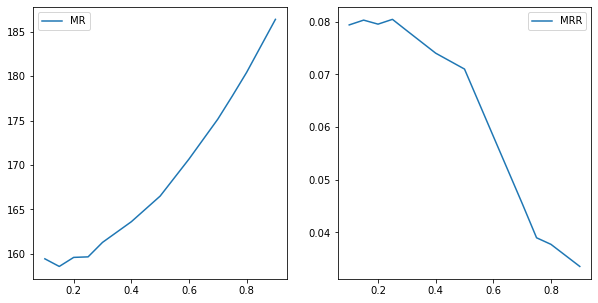

In [12]:
alpha = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
stats = {"mr":[], "mrr":[]}

def remove_neighbors(g, w, v):
    for u in G.neighbors(v[0]): 
        del w[u]
    del w[v[0]]
    
def PPR(k, a):
    global G, extracted_edges
    
    mr = 0
    mrr = 0
    hitsk = 0
    s = len(extracted_edges)
    for v in extracted_edges:
        weights = nx.pagerank(G, alpha = a, personalization = {v[0]:1})
        remove_neighbors(G, weights, v)
        cx = list(weights.items())
        cx.sort(reverse=True, key=lambda x: x[1])
        for i in range(len(cx)):
            if cx[i][0] == v[1]:
                mr += i + 1
                mrr += 1/(i + 1)
                if i + 1 <= k: hitsk+=1
    return (mr/s, mrr/s, hitsk/s)

for a in alpha:
    stats["mr"].append(PPR(1, a)[0])
    stats["mrr"].append(PPR(1, a)[1])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
sns.lineplot(x=alpha, y=stats["mr"], legend='brief', label=str('MR'), ax=axs[0])
sns.lineplot(x=alpha, y=stats["mrr"], legend='brief', label=str('MRR'), ax=axs[1])    


# Comments

<ul>
    <li>
        MR and MPR metrics are used in cases where there is only one real choice. The metric MRR tells us how accurate the predictions of the algorithm are, and can be considered a variation of the metric success @ k. If the MRR is close to 1 then the correct recommendations will be very high in the ranking with a high probability.
        On the contrary, the metric MR gives us the average ranking (position) of the relevant recommendation in the list of
        recommendations.
    </li>
    <li>
        From the graphs we observe that as we increase the alpha and at the same time reduce the jump probability the performance of the algorithm drops significantly. For small values ​​of the alpha parameter and high jump probability we have more restarts from the x node with the result that the nearby nodes get more probability since the weights decrease exponentially, and the algorithm gives better results. From the diagrams we see that when alpha = 0.15 we have the best performance.
    </li>
</ul>

# Step 3

## Neighbor Jaccard Similarity and Common Neighbors vs PPR

In [13]:

def CN(k):
    global G, extracted_edges
    
    mr = 0
    mrr = 0
    hitsk = 0
    s = len(extracted_edges)
    for e in extracted_edges:
        sx = []
        n1 = set(G.neighbors(e[0]))
        for v in G.nodes:
            if not v in n1 and v != e[0]:
                n2 = set(G.neighbors(v))
                common = len(n1.intersection(n2))
                sx.append((v, common))
        sx.sort(reverse=True, key=lambda x: x[1])
        for i in range(len(sx)):
            if e[1] == sx[i][0]:
                mr += i + 1
                mrr += 1/(i + 1)
                if i + 1 <= k: hitsk+=1
    return (mr/s, mrr/s, hitsk/s)
    
def NJS(k):
    global G, extracted_edges
    
    mr = 0
    mrr = 0
    hitsk = 0
    s = len(extracted_edges)
    for e in extracted_edges:
        sx = []
        n1 = set(G.neighbors(e[0]))
        for v in G.nodes:
            if not v in n1 and v != e[0]:
                n2 = set(G.neighbors(v))
                njs = len(n1.intersection(n2))/len(n1.union(n2))
                sx.append((v, njs))
        sx.sort(reverse=True, key=lambda x: x[1])
        for i in range(len(sx)):
            if e[1] == sx[i][0]:
                mr += i + 1
                mrr += 1/(i + 1)
                if i + 1 <= k: hitsk+=1
    return (mr/s, mrr/s, hitsk/s)
    
print('--------------------------------')
print('Scores for CN:' )
e = CN(1)
print('MR: ', e[0])
print('MRR: ', e[1])
print('--------------------------------')

print('Scores for NJS:' )
e = NJS(1)
print('MR: ', e[0])
print('MRR: ', e[1])
print('--------------------------------')

print('Scores for PPR with a = 0.15:' )
e = PPR(1, 0.15)
print('MR: ', e[0])
print('MRR: ', e[1])
print('--------------------------------')


--------------------------------
Scores for CN:
MR:  228.96
MRR:  0.03636532226960041
--------------------------------
Scores for NJS:
MR:  251.13
MRR:  0.029707143007056114
--------------------------------
Scores for PPR with a = 0.15:
MR:  158.56
MRR:  0.08031653455753775
--------------------------------


## Success@k

,hits@1,hits@5,hits@10,hits@20,hits@50,hits@75,hits@100
CN,0.01,0.05,0.07,0.11,0.26,0.31,0.33
NJS,0.01,0.04,0.07,0.09,0.19,0.22,0.29
PPR,0.02,0.12,0.17,0.24,0.39,0.48,0.58


<AxesSubplot:>

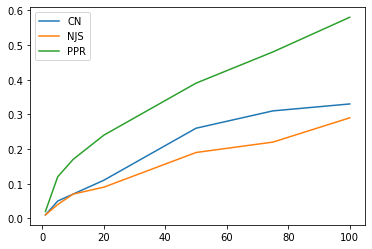

In [14]:
ks = [1,5,10,20,50,75,100]

cn = []
njs = []
ppr = []
for k in ks:
    ppr.append(PPR(k, 0.15)[2])
    cn.append(CN(k)[2])
    njs.append(NJS(k)[2])

hits = [cn, njs, ppr]
df = pd.DataFrame(hits)
df.columns = ['hits@1', 'hits@5', 'hits@10', 'hits@20', 'hits@50', 'hits@75', 'hits@100']
df.index = ['CN', 'NJS', 'PPR']
display(df)

fig, ax = plt.subplots()
sns.lineplot(x=ks, y=cn, ax=ax, label=str('CN'))
sns.lineplot(x=ks, y=njs, ax=ax, label=str('NJS'))
sns.lineplot(x=ks, y=ppr, ax=ax, label=str('PPR'))

# Comments

The CN technique considers that the more common nodes two different nodes have, the greater the likelihood that there will be a correlation between them. The NJS technique is based on the CN method.
We observe that between these three techniques PPR gives the best results because it focuses mainly on the nodes that are closest to the x node, due to high jump probability. In addition, we observe that the CN technique is slightly more efficient than the NJS technique.


# Step 4 - Convert to Undirected

## Determine a

<AxesSubplot:>

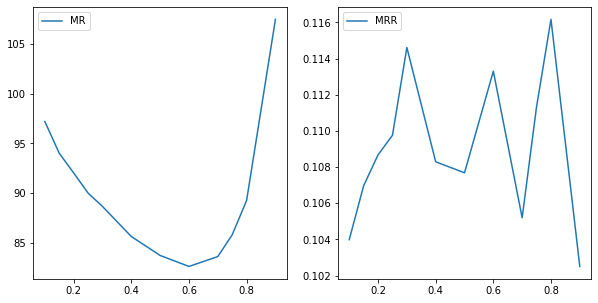

In [15]:
G = G.to_undirected()
alpha = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
stats = {"mr":[], "mrr":[]}

for a in alpha:
    stats["mr"].append(PPR(1, a)[0])
    stats["mrr"].append(PPR(1, a)[1])
    
fig, axs = plt.subplots(1, 2, figsize=(10,5))
sns.lineplot(x=alpha, y=stats["mr"], legend='brief', label=str('MR'), ax=axs[0])
sns.lineplot(x=alpha, y=stats["mrr"], legend='brief', label=str('MRR'), ax=axs[1])

From the graphs we see that for a = 0.6 we get satisfactory results in relation to the other values, because we have the lowest MR and quite high MRR.

## PPR, NJS, CN on the undirected graph

In [16]:
print('--------------------------------')
print('Scores for CN:' )
e = CN(1)
print('MR: ', e[0])
print('MRR: ', e[1])
print('--------------------------------')

print('Scores for NJS:' )
e = NJS(1)
print('MR: ', e[0])
print('MRR: ', e[1])
print('--------------------------------')

print('Scores for PPR with a = 0.6:' )
e = PPR(1, 0.6)
print('MR: ', e[0])
print('MRR: ', e[1])
print('--------------------------------')

--------------------------------
Scores for CN:
MR:  113.53
MRR:  0.10002677734859561
--------------------------------
Scores for NJS:
MR:  163.97
MRR:  0.07358446107259191
--------------------------------
Scores for PPR with a = 0.6:
MR:  82.67
MRR:  0.11330617748129872
--------------------------------


,hits@1,hits@5,hits@10,hits@20,hits@50,hits@75,hits@100
CN,0.05,0.12,0.22,0.33,0.44,0.57,0.64
NJS,0.04,0.09,0.13,0.23,0.32,0.41,0.49
PPR,0.05,0.17,0.24,0.36,0.51,0.66,0.72


<AxesSubplot:>

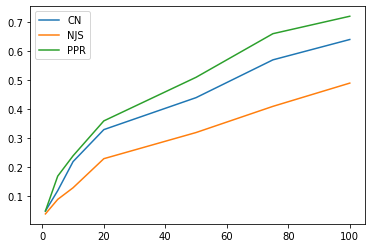

In [17]:
ks = [1,5,10,20,50,75,100]

cn = []
njs = []
ppr = []
for k in ks:
    ppr.append(PPR(k, 0.6)[2])
    cn.append(CN(k)[2])
    njs.append(NJS(k)[2])

hits = [cn, njs, ppr]
df = pd.DataFrame(hits)
df.columns = ['hits@1', 'hits@5', 'hits@10', 'hits@20', 'hits@50', 'hits@75', 'hits@100']
df.index = ['CN', 'NJS', 'PPR']
display(df)

fig, ax = plt.subplots()
sns.lineplot(x=ks, y=cn, ax=ax, label=str('CN'))
sns.lineplot(x=ks, y=njs, ax=ax, label=str('NJS'))
sns.lineplot(x=ks, y=ppr, ax=ax, label=str('PPR'))

# Comments

We observe that the three techniques are most efficient in the case of the non-directed graph.
In the case of CN and NJS, two nodes that are not neighbors may have more common nodes, thus increasing the likelihood of a correlation between them.
In the case of PPR we first notice that the best alpha is different. For this case we have less jump probability and so the algorithm performs longer walks until it returns to the x node. As a result, it emphasizes both nodes that are located at longer distances. While at the same time we see that for all the different a PPR is most effective in the case of the non-directed graph.